In [1]:
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd
from pathlib import Path
from utils import *

In [2]:
root_dir = Path('../input')
train_dir = root_dir/'train'
annot_dir = root_dir/'annotation'

In [3]:
SZ = 224

In [4]:
annotations = json.load(open(annot_dir/'annotations.json'))

In [5]:
len(annotations)

400

In [6]:
annotations[0]

{'annotations': [{'class': 'fluke',
   'height': 372.0,
   'type': 'rect',
   'width': 1017.0,
   'x': 14.0,
   'y': 97.0},
  {'class': 'left',
   'type': 'point',
   'x': 50.802273527488566,
   'y': 98.58659021176},
  {'class': 'notch',
   'type': 'point',
   'x': 516.2391276137811,
   'y': 269.48861474128864},
  {'class': 'right',
   'type': 'point',
   'x': 1013.5305065138045,
   'y': 102.10753986218477}],
 'class': 'image',
 'filename': '6138dce83.jpg'}

In [7]:
anno = annotations[0]['annotations']

In [8]:
anno[1]

{'class': 'left',
 'type': 'point',
 'x': 50.802273527488566,
 'y': 98.58659021176}

In [9]:
img = open_image(train_dir/annotations[0]['filename'])

In [10]:
left_point = ImagePoints(FlowField(img.size, torch.tensor([anno[1]['y'], anno[1]['x']])), scale=True)

In [11]:
point_array = torch.tensor([[anno[1]['y'], anno[1]['x']], 
                            #[anno[2]['y'], anno[2]['x']],
                            [-1, -1],
                            [anno[3]['y'], anno[3]['x']]])

In [12]:
points = ImagePoints(FlowField(img.size, point_array))

In [24]:
def get_key_point(img_file, annotation):
    img = open_image(img_file)
    
    #get bounding box
    bbox = [-1, -1, -1, -1]
    exist = False
    for item in annotation:
        if 'class' in item and item['class'] == 'fluke':
            exist = True
            break
    
    if exist:
        im_height, im_width = img.size
        bb_x, bb_y, bb_width, bb_height = item['x'], item['y'], item['width'], item['height']
        top = np.clip(bb_y, 0, im_height)
        left = np.clip(bb_x, 0, im_width)
        bottom = np.clip(bb_y + bb_height, 0, im_height)
        right = np.clip(bb_x + bb_width, 0, im_width)
        bbox = ImageBBox.create(im_height, im_width, [[top,left, bottom, right]])
    
    #get key points
    key_point_list = []
    for cls_name in ['left', 'notch', 'right']:
        exist = False
        for item in annotation:
            #print(item)
            if 'class' not in item or item['class'] != cls_name:
                continue
            else:
                exist = True
                break
        if exist:
            axis = [item['y'], item['x']]
        else:
            axis= [-1, -1]
        key_point_list.append(axis)
    key_points = ImagePoints(FlowField(img.size, torch.tensor(key_point_list)))
    return bbox, key_points
        

In [25]:
bbox, kp0 = get_key_point(train_dir/annotations[0]['filename'], annotations[0]['annotations'])

In [28]:
bbox, kp0

(ImageBBox (600, 1050), ImagePoints (600, 1050))

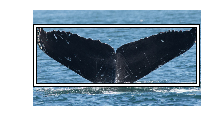

In [29]:
img.show(y=bbox)

In [80]:
top = np.clip(bb_y, 0, im_height)
left = np.clip(bb_x, 0, im_width)
bottom = np.clip(bb_y + bb_height, 0, im_height)
right = np.clip(bb_x + bb_width, 0, im_width)

In [81]:
top, left, bottom, right

(97.0, 14.0, 469.0, 1031.0)

In [82]:
bbox = ImageBBox.create(im_height, im_width, [[top,left, bottom, right]])

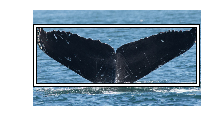

In [83]:
img.show(y=bbox)

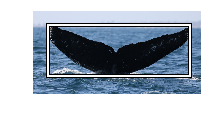

In [40]:
idx = 6
img = open_image(train_dir/annotations[idx]['filename'])
bbox, kp = get_key_point(train_dir/annotations[idx]['filename'], annotations[idx]['annotations'])
img.show(y=bbox)


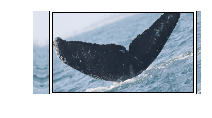

In [45]:
#trans = get_transforms()[0]
#bbox.apply_tfms(trans)
#img.apply_tfms(trans).show(y=bbox)

trans = get_transforms(max_rotate=30)[0]
img = img.apply_tfms(trans)
bbox = bbox.apply_tfms(trans, do_resolve=False) #Second arg to make sure you keep the same random params
img.show(y=bbox)

Now we calcualte the average ratio of the bounding boxes

In [48]:
annotations[0]['annotations']

[{'class': 'fluke',
  'height': 372.0,
  'type': 'rect',
  'width': 1017.0,
  'x': 14.0,
  'y': 97.0},
 {'class': 'left',
  'type': 'point',
  'x': 50.802273527488566,
  'y': 98.58659021176},
 {'class': 'notch',
  'type': 'point',
  'x': 516.2391276137811,
  'y': 269.48861474128864},
 {'class': 'right',
  'type': 'point',
  'x': 1013.5305065138045,
  'y': 102.10753986218477}]

In [50]:
cnt = 0
w = 0
h = 0
for item in annotations:
    annot = item['annotations']
    exist = False
    for e in annot:
        if 'class' in e and e['class'] == 'fluke':
            exist = True
            break
    if exist:
        w += e['width']
        h += e['height']
        cnt += 1
print(w/h)

3.094754586365063


In [51]:
576/192

3.0

In [55]:
576*192, 384**2

(110592, 147456)

In [56]:
384*128, 224**2

(49152, 50176)

In [57]:
9216**0.5

96.0